In [1]:
# Cell 1 - Imports
import tensorflow as tf
import mediapipe as mp
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Cell 2 - MediaPipe Setup
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Class mapping
CLASS_NAMES = ['Prone', 'Supine', 'To-Left', 'To-Right']

In [5]:
# Cell 3 - Updated Data Loading Functions
def load_dataset(base_dir, image_size=(224, 224)):
    """Load and process images from directory structure"""
    images = []
    labels = []
    
    image_files = glob(os.path.join(base_dir, 'images', '*.*'))
    
    for image_path in image_files:
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            continue
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)
        
        # Get label from YOLO format
        label_file = os.path.join(
            base_dir, 
            'labels', 
            os.path.basename(image_path).replace('.jpg', '.txt')
        )
        
        try:
            with open(label_file, 'r') as f:
                # YOLO format: class x y width height
                # We only need the class (first number)
                label = int(f.read().split()[0])
            
            # Extract pose landmarks
            results = pose.process(image)
            if results.pose_landmarks:
                landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark])
                landmarks = landmarks.flatten()
                images.append(landmarks)
                labels.append(label)
                
        except (IndexError, ValueError, FileNotFoundError) as e:
            print(f"Skipping {image_path}: {str(e)}")
            continue
            
    if not images:
        raise ValueError(f"No valid images found in {base_dir}")
        
    return np.array(images), np.array(labels)

In [6]:
# Cell 4 - Load Data
# Load datasets
train_images, train_labels = load_dataset('train')
valid_images, valid_labels = load_dataset('valid')
test_images, test_labels = load_dataset('test')

# Create TF datasets
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))\
    .shuffle(1000).batch(BATCH_SIZE)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))\
    .batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))\
    .batch(BATCH_SIZE)

Skipping valid\images\image-1-_png_jpg.rf.34c583d25d48382d7f7b08bbb9213965.jpg: list index out of range


In [10]:
# Cell 5 - Model Architecture
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(99,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               12800     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [11]:
# Cell 6 - Training
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


77/77 [==============================] - 1s 6ms/step - loss: 1.0468 - accuracy: 0.5603 - val_loss: 1.0820 - val_accuracy: 0.6194 - lr: 0.0010
Epoch 2/100
77/77 [==============================] - 0s 4ms/step - loss: 0.7495 - accuracy: 0.7073 - val_loss: 0.8765 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 3/100
77/77 [==============================] - 0s 5ms/step - loss: 0.6595 - accuracy: 0.7516 - val_loss: 0.7361 - val_accuracy: 0.7042 - lr: 0.0010
Epoch 4/100
77/77 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.7623 - val_loss: 0.5980 - val_accuracy: 0.7833 - lr: 0.0010
Epoch 5/100
77/77 [==============================] - 0s 4ms/step - loss: 0.5638 - accuracy: 0.7878 - val_loss: 0.5360 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 6/100
77/77 [==============================] - 0s 4ms/step - loss: 0.5503 - accuracy: 0.7939 - val_loss: 0.4688 - val_accuracy: 0.8431 - lr: 0.0010
Epoch 7/100
77/77 [==============================] - 0s 4ms/step - loss: 0.5328 - accura

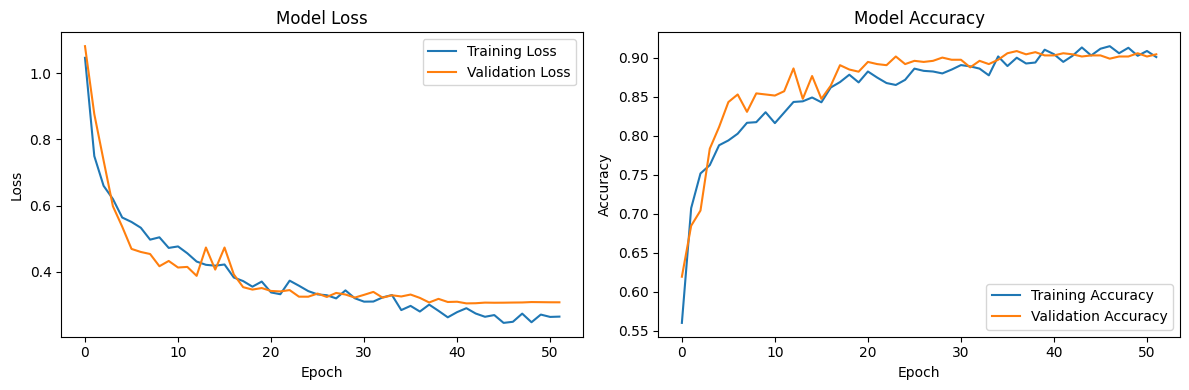

In [12]:
# Cell 7 - Visualization Functions
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

1/1 [==============================] - 0s 59ms/step


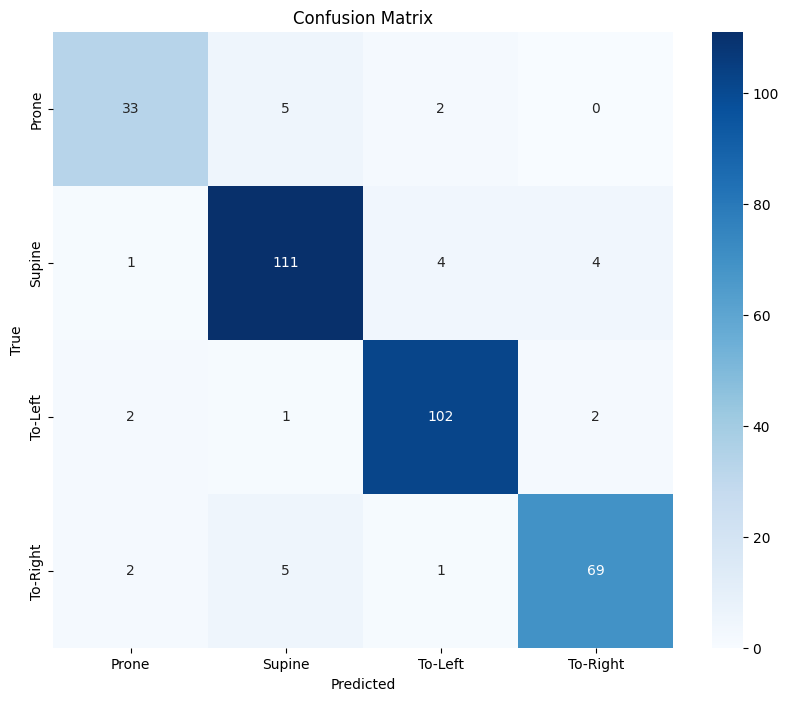


Test Results:
11/11 [==============================] - 0s 2ms/step - loss: 0.3066 - accuracy: 0.9157
Test accuracy: 0.9157


In [13]:
# Cell 8 - Model Evaluation
def evaluate_model(model, test_ds):
    # Get predictions
    y_pred = []
    y_true = []
    
    for images, labels in test_ds:
        pred = model.predict(images)
        y_pred.extend(np.argmax(pred, axis=1))
        y_true.extend(labels.numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Print classification report
    print("\nTest Results:")
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"Test accuracy: {test_acc:.4f}")

# Evaluate model
evaluate_model(model, test_ds)

In [15]:
# Cell 9 - Save Model
model.save('sleep_posture_model.h5')